In [18]:
import numpy as np
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
import time
from scipy.optimize import root_scalar, minimize
from scipy.stats import gamma
from scipy.stats import beta
from scipy.linalg import block_diag
import random
import pandas as pd
from functools import reduce

import gurobipy as gp
from gurobipy import GRB

# Constants
# peak hours
pcoef = 65./168
# off-peak hours
opcoef = 103./168
# conversion of hourly revenue per MW into annual revenue per kW
convcoef = 24.*365.25/1000.
# baseline supply
def F0(X):
    return 17.5*X/150.
# Integrated baseline supply function
def G0(X):
    return 17.5*X*X/300.
# price cap
Pmax = 200


class Agent: # Base class for any producer

    def __init__(self,name,cp,ap):
        # name : name of agent
        # cp : common parameters
        # ap : agent parameters
        # described in derived classes
        self.name = name
        self.Nt = cp['Nt']
        self.NX = ap['NX']
        self.Na=2
        self.Amax=cp['tmax']
        #if self.Na==1:
        #    self.da=1
        #else:
        self.da=  1.*(self.Amax)/(self.Na-1)
        
        self.dX = 1.*(ap['Xmax']-ap['Xmin'])/(self.NX-1)
        self.dt = 1.*(cp['tmax']-cp['tmin'])/(self.Nt-1)
        self.X = np.linspace(ap['Xmin'],ap['Xmax'],self.NX)
        self.T = np.linspace(cp['tmin'],cp['tmax'],self.Nt)
        self.rho = ap['discount rate']
        self.gamma0 = ap['depreciation rate']
        self.rCost = ap['running cost']
        self.fCost = ap['fixed cost']
        self.sCost = ap['scrap value']
        self.tmax = cp['tmax']
        self.m_ = np.zeros((self.Nt,self.Na,self.NX))
        self.mhat_ = np.zeros((self.Nt,self.Na,self.NX))
        self.mu_ = np.zeros((self.Nt,self.Na,self.NX))
        self.muhat_ = np.zeros((self.Nt,self.Na,self.NX))




    def preCalc(self,indens,indenshat,V,V0,V1,V2):
        # Some technical preliminary computations
        self.m_[0,:] = indens[:]
        #print(indens)
        self.mhat_[0,:] = indenshat[:]
        #print(indenshat)
        with gp.Env(empty=True) as env:
            env.setParam('OutputFlag', 0)
            env.start()
            self.model = gp.Model(env=env)
        self.mhat= [[[self.model.addVar() for _ in range(self.NX)] for _ in range(self.Na)] for _ in range(self.Nt-1)]
        self.m = [[[self.model.addVar() for _ in range(self.NX)] for _ in range(self.Na)] for _ in range(self.Nt-1)]
        self.muhat = [[[self.model.addVar() for _ in range(self.NX)] for _ in range(self.Na)] for _ in range(self.Nt-1)]
        self.mu = [[[self.model.addVar() for _ in range(self.NX)] for _ in range(self.Na)] for _ in range(self.Nt-1)]
        
        
        #i!=0, z!=0 z!=Na-1, j!=0 and j!=NX-1
        for i in range(1,self.Nt-1):
            for z in range(1,self.Na-1):
                for j in range(1,self.NX-1):
                    expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt,-self.dt,-1.,-self.dt/self.da],[self.m[i][z][j],self.m[i][z][j+1],self.m[i][z][j-1],self.mu[i][z][j],self.muhat[i][z][j],self.m[i-1][z][j],self.m[i][z-1][j]])
                    #expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],-self.dt/self.da, self.dt,-self.dt,-1.],[self.m[i][z][j],self.m[i][z][j+1],self.m[i][z][j-1],self.m[i][z-1][j],self.mu[i][z][j],self.muhat[i][z][j],self.m[i-1][z][j]])
                    self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
                    expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt,-1.,-self.dt/self.da],[self.mhat[i][z][j],self.mhat[i][z][j+1],self.mhat[i][z][j-1],self.muhat[i][z][j],self.mhat[i-1][z][j],self.mhat[i][z-1][j]])
                    self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
        #i!=0, z!=0, j=0 or j=NX-1
                expr = gp.LinExpr([V[0],V1[1],self.dt,-self.dt,-1.,-self.dt/self.da],[self.m[i][z][0],self.m[i][z][1],self.mu[i][z][0],self.muhat[i][z][0],self.m[i-1][z][0],self.m[i][z-1][0]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
                expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt,-self.dt,-1.,-self.dt/self.da],[self.m[i][z][self.NX-1],self.m[i][z][self.NX-2],self.mu[i][z][self.NX-1],self.muhat[i][z][self.NX-1],self.m[i-1][z][self.NX-1],self.m[i][z-1][self.NX-1]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
                expr = gp.LinExpr([V[0],V1[1],self.dt,-1.,-self.dt/self.da],[self.mhat[i][z][0],self.mhat[i][z][1],self.muhat[i][z][0],self.mhat[i-1][z][0],self.mhat[i][z-1][0]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
                expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt,-1.,-self.dt/self.da],[self.mhat[i][z][self.NX-1],self.mhat[i][z][self.NX-2],self.muhat[i][z][self.NX-1],self.mhat[i-1][z][self.NX-1],self.mhat[i][z-1][self.NX-1]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
        
        #i!=0, z=0, j!=0 and j!=NX-1
            for j in range(1,self.NX-1):
                expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt,-self.dt,-1.],[self.m[i][0][j],self.m[i][0][j+1],self.m[i][0][j-1],self.mu[i][0][j],self.muhat[i][0][j],self.m[i-1][0][j]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
                expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt,-1.],[self.mhat[i][0][j],self.mhat[i][0][j+1],self.mhat[i][0][j-1],self.muhat[i][0][j],self.mhat[i-1][0][j]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
        #i!=0, z=0, j=0 or j=NX-1
            expr = gp.LinExpr([V[0],V1[1],self.dt,-self.dt,-1.],[self.m[i][0][0],self.m[i][0][1],self.mu[i][0][0],self.muhat[i][0][0],self.m[i-1][0][0]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
            expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt,-self.dt,-1.],[self.m[i][0][self.NX-1],self.m[i][0][self.NX-2],self.mu[i][0][self.NX-1],self.muhat[i][0][self.NX-1],self.m[i-1][0][self.NX-1]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
            expr = gp.LinExpr([V[0],V1[1],self.dt,-1.],[self.mhat[i][0][0],self.mhat[i][0][1],self.muhat[i][0][0],self.mhat[i-1][0][0]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
            expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt,-1.],[self.mhat[i][0][self.NX-1],self.mhat[i][0][self.NX-2],self.muhat[i][0][self.NX-1],self.mhat[i-1][0][self.NX-1]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
        #i!=0, z=Na-1, j!=0 and j!=NX-1
            for j in range(1,self.NX-1):
                expr = gp.LinExpr([V0[j],V1[j+1],V2[j-1],self.dt,-self.dt,-1.],[self.m[i][self.Na-1][j],self.m[i][self.Na-1][j+1],self.m[i][self.Na-1][j-1],self.mu[i][self.Na-1][j],self.muhat[i][self.Na-1][j],self.m[i-1][self.Na-1][j]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
                expr = gp.LinExpr([V0[j],V1[j+1],V2[j-1],self.dt,-1.],[self.mhat[i][self.Na-1][j],self.mhat[i][self.Na-1][j+1],self.mhat[i][self.Na-1][j-1],self.muhat[i][self.Na-1][j],self.mhat[i-1][self.Na-1][j]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
        #i!=0, z=Na-1, j=0 or j=NX-1
            expr = gp.LinExpr([V0[0],V1[1],self.dt,-self.dt,-1.],[self.m[i][self.Na-1][0],self.m[i][self.Na-1][1],self.mu[i][self.Na-1][0],self.muhat[i][self.Na-1][0],self.m[i-1][self.Na-1][0]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
            expr = gp.LinExpr([V0[self.NX-1],V2[self.NX-2],self.dt,-self.dt,-1.],[self.m[i][self.Na-1][self.NX-1],self.m[i][self.Na-1][self.NX-2],self.mu[i][self.Na-1][self.NX-1],self.muhat[i][self.Na-1][self.NX-1],self.m[i-1][self.Na-1][self.NX-1]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
            expr = gp.LinExpr([V0[0],V1[1],self.dt,-1.],[self.mhat[i][self.Na-1][0],self.mhat[i][self.Na-1][1],self.muhat[i][self.Na-1][0],self.mhat[i-1][self.Na-1][0]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)
            expr = gp.LinExpr([V0[self.NX-1],V2[self.NX-2],self.dt,-1.],[self.mhat[i][self.Na-1][self.NX-1],self.mhat[i][self.Na-1][self.NX-2],self.muhat[i][self.Na-1][self.NX-1],self.mhat[i-1][self.Na-1][self.NX-1]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=0.)

        #i=0,z!=0,z!=Na-1, j!=0 and j!=NX-1
        for z in range(1,self.Na-1):
            for j in range(1,self.NX-1):
                expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt,-self.dt,-self.dt/self.da],[self.m[0][z][j],self.m[0][z][j+1],self.m[0][z][j-1],self.mu[0][z][j],self.muhat[0][z][j],self.m[0][z-1][j]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[z,j])
                expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt,-self.dt/self.da],[self.mhat[0][z][j],self.mhat[0][z][j+1],self.mhat[0][z][j-1],self.muhat[0][z][j],self.mhat[0][z-1][j]])
                self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[z,j])
       #i=0, z!=0, j=0 or j=NX-1
            expr = gp.LinExpr([V[0],V1[1],self.dt,-self.dt,-self.dt/self.da],[self.m[0][z][0],self.m[0][z][1],self.mu[0][z][0],self.muhat[0][z][0],self.m[0][z-1][0]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[z,0])
            expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt,-self.dt,-self.dt/self.da],[self.m[0][z][self.NX-1],self.m[0][z][self.NX-2],self.mu[0][z][self.NX-1],self.muhat[0][z][self.NX-1],self.m[0][z-1][self.NX-1]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[z,self.NX-1])
            expr = gp.LinExpr([V[0],V1[1],self.dt,-self.dt/self.da],[self.mhat[0][z][0],self.mhat[0][z][1],self.muhat[0][z][0],self.mhat[0][z-1][0]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[z,0])
            expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt,-self.dt/self.da],[self.mhat[0][z][self.NX-1],self.mhat[0][z][self.NX-2],self.muhat[0][z][self.NX-1],self.mhat[0][z-1][self.NX-1]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[z,self.NX-1])
        #i=0, z=0, j!=0 and j!=NX-1
        for j in range(1,self.NX-1):
            expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt,-self.dt],[self.m[0][0][j],self.m[0][0][j+1],self.m[0][0][j-1],self.mu[0][0][j],self.muhat[0][0][j]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[0,j])
            expr = gp.LinExpr([V[j],V1[j+1],V2[j-1],self.dt],[self.mhat[0][0][j],self.mhat[0][0][j+1],self.mhat[0][0][j-1],self.muhat[0][0][j]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[0,j])
            
        #i=0, z=0, j=0 or j=NX-1
        expr = gp.LinExpr([V[0],V1[1],self.dt,-self.dt],[self.m[0][0][0],self.m[0][0][1],self.mu[0][0][0],self.muhat[0][0][0]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[0,0])
        expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt,-self.dt],[self.m[0][0][self.NX-1],self.m[0][0][self.NX-2],self.mu[0][0][self.NX-1],self.muhat[0][0][self.NX-1]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[0,self.NX-1])
        expr = gp.LinExpr([V[0],V1[1],self.dt],[self.mhat[0][0][0],self.mhat[0][0][1],self.muhat[0][0][0]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[0,0])
        expr = gp.LinExpr([V[self.NX-1],V2[self.NX-2],self.dt],[self.mhat[0][0][self.NX-1],self.mhat[0][0][self.NX-2],self.muhat[0][0][self.NX-1]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[0,self.NX-1])
        #i=0, z=Na-1, j!=0, and  j!=NX-1
        for j in range(1,self.NX-1):
            expr = gp.LinExpr([V0[j],V1[j+1],V2[j-1],self.dt,-self.dt],[self.m[0][self.Na-1][j],self.m[0][self.Na-1][j+1],self.m[0][self.Na-1][j-1],self.mu[0][self.Na-1][j],self.muhat[0][self.Na-1][j]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[self.Na-1,j])
            expr = gp.LinExpr([V0[j],V1[j+1],V2[j-1],self.dt],[self.mhat[0][self.Na-1][j],self.mhat[0][self.Na-1][j+1],self.mhat[0][self.Na-1][j-1],self.muhat[0][self.Na-1][j]])
            self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[self.Na-1,j])
            
        #i=0, z=Na-1, j=0 or j=NX-1
        expr = gp.LinExpr([V0[0],V1[1],self.dt,-self.dt],[self.m[0][self.Na-1][0],self.m[0][self.Na-1][1],self.mu[0][self.Na-1][0],self.muhat[0][self.Na-1][0]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[self.Na-1,0])
        expr = gp.LinExpr([V0[self.NX-1],V2[self.NX-2],self.dt,-self.dt],[self.m[0][self.Na-1][self.NX-1],self.m[0][self.Na-1][self.NX-2],self.mu[0][self.Na-1][self.NX-1],self.muhat[0][self.Na-1][self.NX-1]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indens[self.Na-1,self.NX-1])
        expr = gp.LinExpr([V0[0],V1[1],self.dt],[self.mhat[0][self.Na-1][0],self.mhat[0][self.Na-1][1],self.muhat[0][self.Na-1][0]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[self.Na-1,0])
        expr = gp.LinExpr([V0[self.NX-1],V2[self.NX-2],self.dt],[self.mhat[0][self.Na-1][self.NX-1],self.mhat[0][self.Na-1][self.NX-2],self.muhat[0][self.Na-1][self.NX-1]])
        self.model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=indenshat[self.Na-1,self.NX-1])


    def bestResponse(self, peakPr, offpeakPr, cPrice, fPrice):
        # best response function
        # peakPr : peak price vector
        # offpeakPr : offpeak price vector
        # fPr : vector of fuel prices
        runGain = gp.LinExpr()
        entryGain = gp.LinExpr()
        exitGain = gp.LinExpr()
        curval = 0
        for i in range(self.Nt-1):
            for j in range(self.Na):
                H = self.dX*self.dt*self.da*np.exp(-self.rho*(self.T[i+1]))*(pcoef*self.gain(peakPr[i+1],cPrice[i+1],fPrice[:,i+1])+opcoef*self.gain(offpeakPr[i+1],cPrice[i+1], fPrice[:,i+1]))
                runGain.addTerms(H,self.m[i][j])
                #print(runGain)
                curval = curval + np.sum(H*self.m_[i+1,j,:])

                H = -self.fCost*self.dX*self.da*self.dt*np.exp(-(self.rho+self.gamma0)*(self.T[i+1]))*np.ones(self.NX)
                entryGain.addTerms(H,self.muhat[i][j])
                curval = curval + np.sum(H*self.muhat_[i+1,j,:])
                H = self.sCost*self.dX*self.dt*self.da*np.exp(-(self.rho+self.gamma0)*(self.T[i+1]))*np.ones(self.NX)
                exitGain.addTerms(H,self.mu[i][j])
                curval = curval + np.sum(H*self.mu_[i+1,j,:])

       
        obj = runGain+entryGain+exitGain
        
        self.model.setObjective(obj,GRB.MAXIMIZE)
        self.model.update()
        #print(obj)
        self.model.optimize()
        if self.model.SolCount ==0:
            print('no solution')
       #print('obj=')
       #print(self.model.objVal)
        sol_m = [[[self.m[j][z][i].X for i in range(self.NX)] for z in range(self.Na)] for j in range(self.Nt-1)]
       # print(sol_m[0])
        sol_mhat = [[[self.mhat[j][z][i].X for i in range(self.NX)] for z in range(self.Na)]for j in range(self.Nt-1)]
        sol_mu = [[[self.mu[j][z][i].X for i in range(self.NX)] for z in range(self.Na)] for j in range(self.Nt-1)]
        sol_muhat = [[[self.muhat[j][z][i].X for i in range(self.NX)] for z in range(self.Na)]for j in range(self.Nt-1)]


        ob_func = obj.getValue()- curval
        return ob_func, curval, np.array(sol_m),np.array(sol_mhat),np.array(sol_mu),np.array(sol_muhat)

    def update(self,weight,m,mhat,mu,muhat):
        # density update with given weight
        self.m_[1:,:,:] = (1.-weight)*self.m_[1:,:,:]+weight*m
        self.mhat_[1:,:,:] = (1.-weight)*self.mhat_[1:,:,:]+weight*mhat
        self.mu_[1:,:,:] = (1.-weight)*self.mu_[1:,:,:]+weight*mu
        self.muhat_[1:,:,:] = (1.-weight)*self.muhat_[1:,:,:]+weight*muhat

    def capacity(self):
        return np.sum(np.sum(self.m_,axis=1),axis=1)*self.dX*self.da
    def pot_capacity(self):
        return np.sum(np.sum(self.mhat_,axis=1),axis=1)*self.dX*self.da
    def exit_measure(self):
        return np.sum(np.sum(self.mu_,axis=1),axis=1)*self.dX*self.da
    def entry_measure(self):
        return np.sum(np.sum(self.muhat_,axis=1),axis=1)*self.dX*self.da


class Conventional(Agent):
# Base class for conventional producer
    epsilon = 0.5 # parameter of the supply function
    def __init__(self,name,cp,ap):
        Agent.__init__(self,name,cp,ap)
        self.cTax = ap['emissions']
        self.fuel = ap['fuel']
        self.cFuel = ap['cFuel']
        kappa = ap['mean reversion']
        theta = ap['long term mean']
        stdIn = ap['standard deviation']
        delta = stdIn*np.sqrt(2.*kappa/theta)
        V=1.+delta*delta*self.X*self.dt/(self.dX*self.dX)+self.dt/self.da
        V0=1.+delta*delta*self.X*self.dt/(self.dX*self.dX)-self.dt
        #print(V)
        V1 =-delta*delta*self.X*self.dt/(2*self.dX*self.dX)+kappa*(theta-self.X)*self.dt/(2*self.dX)
        #print(V1)
        V2=-delta*delta*self.X*self.dt/(2*self.dX*self.dX)-kappa*(theta-self.X)*self.dt/(2*self.dX)
        alpha = (theta/stdIn)*(theta/stdIn)
        bet = theta/stdIn/stdIn
        indens=np.zeros((self.Na,self.NX))
        indenshat=np.zeros((self.Na,self.NX))
        for i in range(len(indens)):
            indens[i] = ap['initial capacity']*bet*gamma.pdf(bet*self.X,alpha)/self.Na/self.da
            indenshat[i] = ap['potential capacity']*bet*gamma.pdf(bet*self.X,alpha)/self.Na/self.da
        self.preCalc(indens,indenshat,V,V0,V1,V2)
    def G(self,x):
        # Gain function
        return (self.epsilon/2+(x-self.epsilon))*(x>self.epsilon)+x*x/2/self.epsilon*(x>0)*(x<=self.epsilon)
    def F(self,x):
        # Supply function
        return (x-self.epsilon>0)+x/self.epsilon*(x>0)*(x<=self.epsilon)
    def gain(self,p, cp, fp):
        return (convcoef*self.G(p-self.cFuel*fp[self.fuel]-self.X-self.cTax*cp) - self.rCost)
    def offer(self,p,cp, fp, t):
        return sum(self.F(p-self.cFuel*fp[self.fuel]-self.X-self.cTax*cp)*np.sum(self.m_[t,:,:],axis=0))*self.dX*self.da
    def ioffer(self,p,cp,fp,t):
        return sum(self.G(p-self.cFuel*fp[self.fuel]-self.X-self.cTax*cp)*np.sum(self.m_[t,:,:],axis=0))*self.dX*self.da
    def full_offer(self,price, cPrice, fPrice):
        # agent supply for given price level
        res = np.zeros(self.Nt)
        for i in range(self.Nt):
            res[i] = self.offer(price[i], cPrice[i], fPrice[:,i],i)
        return res





class Renewable(Agent):
    def __init__(self,name,cp,ap):
        Agent.__init__(self,name,cp,ap)
        kappa = ap['mean reversion']
        theta = ap['long term mean']
        stdIn = ap['standard deviation']
        delta = stdIn*np.sqrt(2.*kappa/(theta*(1-theta)-stdIn*stdIn))
        V=1.+delta*delta*self.X*(1-self.X)*self.dt/(self.dX*self.dX)+self.dt/self.da
        V0=1.+delta*delta*self.X*(1-self.X)*self.dt/(self.dX*self.dX)-self.dt
        V1 = -delta*delta*self.X*(1.-self.X)*self.dt/(2*self.dX*self.dX)+kappa*(theta-self.X)*self.dt/(2*self.dX)
        V2 = -delta*delta*self.X*(1.-self.X)*self.dt/(2*self.dX*self.dX)-kappa*(theta-self.X)*self.dt/(2*self.dX)
        alpha = theta*(theta*(1.-theta)/stdIn/stdIn-1.)
        bet = (1.-theta)*(theta*(1.-theta)/stdIn/stdIn-1.)
        indens=np.zeros((self.Na,self.NX))
        indenshat=np.zeros((self.Na,self.NX))
        for i in range(len(indens)):
            indens[i] = ap['initial capacity']*beta.pdf(self.X,alpha,bet)/self.da/self.Na
            indenshat[i] = ap['potential capacity']*beta.pdf(self.X,alpha,bet)/self.da/self.Na
        self.preCalc(indens,indenshat,V,V0,V1,V2)
    def gain(self,p,cp,fp):
        return convcoef*p*self.X - self.rCost
    def offer(self,t):
        return sum(self.X*np.sum(self.m_[t,:,:],axis=0))*self.dX*self.da
    def full_offer(self):
        # agent supply for given price level
        res = np.zeros(self.Nt)
        for i in range(self.Nt):
            res[i] = self.offer(i)
        return res


class Simulation:
    # main class for performing the simulation
    def __init__(self, cagents, ragents, cp):
        # agents: list of agent class instances
        # cp : common parameters
        self.cagents = cagents# conventional
        self.ragents = ragents# renewable
        self.Nt = cp['Nt']
        self.T = np.linspace(cp['tmin'],cp['tmax'],self.Nt)
        self.pdemand = np.array(cp["demand"])*cp["demand ratio"]/(pcoef*cp["demand ratio"]+opcoef)
        self.opdemand = np.array(cp["demand"])/(pcoef*cp["demand ratio"]+opcoef)
        self.Prp = np.zeros(self.Nt)
        self.Prop = np.zeros(self.Nt)
        self.Nfuels = cp['Nfuels']
        self.fTax = np.interp(self.T,cp['carbon tax'][0],cp['carbon tax'][1])
        self.acoef = np.array(cp['Fsupply'][0])
        self.bcoef = np.array(cp['Fsupply'][1])
        self.fPrice = np.zeros((self.Nfuels,self.Nt))

    def psibar(self,x):
        return np.sum(self.bcoef*(x-self.acoef)**2/2.)

    def calcPrice(self):
        # compute price for given demand profile
        def opfunc(x,t):
            # x = [pp,pop,p1...pK]
            rdem = reduce(lambda a,b:a+b.offer(t),self.ragents,0)
            res = self.psibar(x[2:])
            for ag in self.cagents:
                res = res + pcoef*ag.ioffer(x[0],self.fTax[t],x[2:],t) + opcoef*ag.ioffer(x[1],self.fTax[t],x[2:],t)
            return res+pcoef*x[0]*(rdem-self.pdemand[t])+opcoef*x[1]*(rdem-self.opdemand[t])+pcoef*G0(x[0])+opcoef*G0(x[1])

        for j in range(self.Nt):
            x0 = np.zeros(self.Nfuels+2)
            x0[0] = self.Prp[j]
            x0[1] = self.Prop[j]
            x0[2:] = self.fPrice[:,j]
            bds = [(0,Pmax),(0,Pmax)]+[(0,None)]*self.Nfuels
            opres = minimize(lambda x:opfunc(x,j),x0,bounds=bds)
            self.Prp[j]=opres.x[0]
            self.Prop[j] = opres.x[1]
            self.fPrice[:,j] = opres.x[2:]

    def run(self,Niter,tol,power=1., shift=1):
        # run the simulation with maximum Niter iterations
        # the program will stop when the total increase of objective function is less than tol
        # power and shift are coefficients in the weight update formula
        conv = np.zeros(Niter)
        start = time.time()
        for i in range(Niter):
            self.calcPrice()
            weight = np.power(1./(i+shift),power)
            print("Iteration",i)
            message = "Weight: {:.4f}".format(weight)
            obtot = 0
            for a in self.ragents:
                ob, val, m,mhat,mu,muhat = a.bestResponse(self.Prp,self.Prop,self.fTax,self.fPrice)
                a.update(weight,m,mhat,mu,muhat)
                message = message+"; "+a.name+": {:.2f}".format(ob)
                obtot = obtot+ob
            for a in self.cagents:
                ob, val, m,mhat,mu,muhat = a.bestResponse(self.Prp,self.Prop,self.fTax,self.fPrice)
                a.update(weight,m,mhat,mu,muhat)
                message = message+"; "+a.name+": {:.2f}".format(ob)
                obtot = obtot+ob

            message = message + "; Total: {:.2f}".format(obtot)
            conv[i] = obtot
            print(message)
            if(obtot<tol):
                Niter = i
                break
        self.calcPrice()
        end = time.time()
        return conv, end-start, Niter

    def write(self, scenario_name):
        # write simulation output into a file scenario_name
        output = {"time": self.cagents[0].T, "peak price":self.Prp,"offpeak price":self.Prop,
                  "peak demand":self.pdemand, "offpeak demand":self.opdemand}
        for a in self.cagents:
            output[a.name+" capacity"] = a.capacity()
            output[a.name+" potential capacity"] = a.pot_capacity()
            output[a.name+" exit measure"] = a.exit_measure()
            output[a.name+" entry measure"] = a.entry_measure()
            output[a.name+" peak supply"] = a.full_offer(self.Prp,self.fTax, self.fPrice)
            output[a.name+" offpeak supply"] = a.full_offer(self.Prop,self.fTax,self.fPrice)
        for a in self.ragents:
            output[a.name+" capacity"] = a.capacity()
            output[a.name+" potential capacity"] = a.pot_capacity()
            output[a.name+" exit measure"] = a.exit_measure()
            output[a.name+" entry measure"] = a.entry_measure()
            output[a.name+" peak supply"] = a.full_offer()
            output[a.name+" offpeak supply"] = a.full_offer()
        for i in range(self.Nfuels):
            output["Fuel "+str(i)] = self.fPrice[i,:]
        df = pd.DataFrame.from_dict(output)
        df.to_csv(scenario_name+'.csv')
        return output


def getpar(fname):
    # service function: extract parameter dictionary from file
    with open(fname) as f:
        data = f.read()
    return eval(data)

In [19]:
import os as os
scenario_name = "test" # this will be the name of the output file & folder

cp = getpar("common_params.py")

# list of conventional agents; modify this to add / remove agent types
cagents = [Conventional('Coal',cp,getpar('coal.py')),
          Conventional('Gas',cp,getpar('gas.py'))]

# list of renewable agents; modify this to add / remove agent types
ragents = [Renewable('Renewable',cp,getpar('renewable.py'))]
Niter = cp['iterations']
#tol = cp['tolerance']
tol = 50
sim = Simulation(cagents,ragents,cp)
conv, elapsed, Nit = sim.run(Niter, tol, cp['power'], cp['offset'])

Iteration 0
no solution


AttributeError: Unable to retrieve attribute 'X'

Elapsed time:  111.16998672485352
Directory already exists


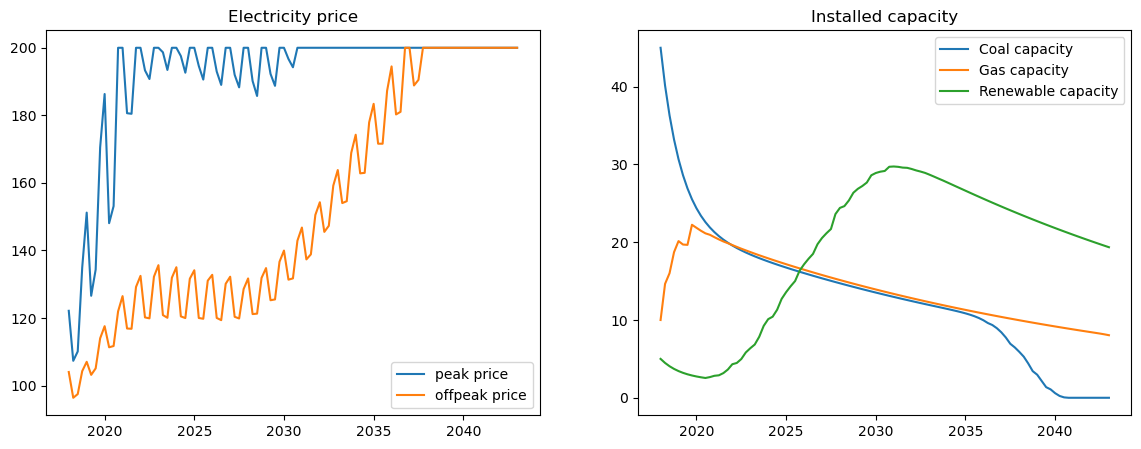

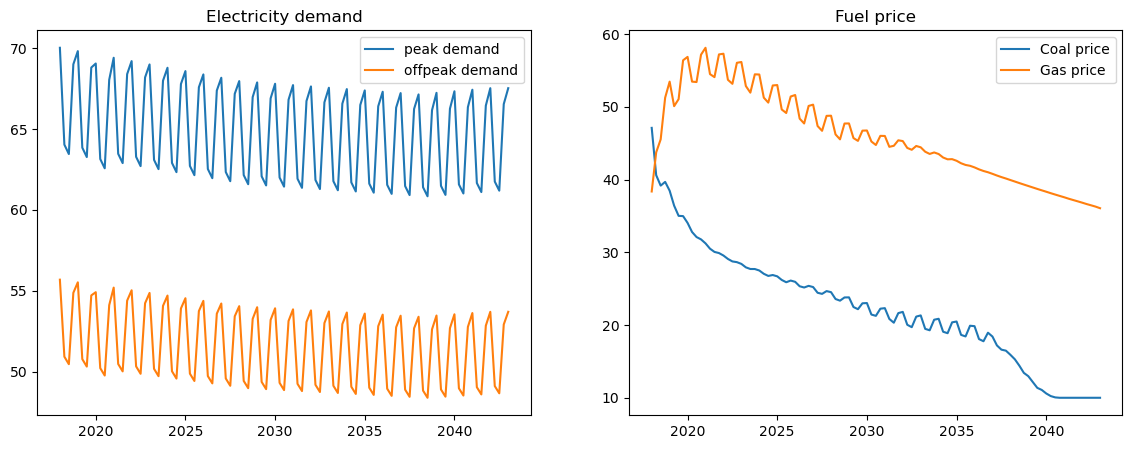

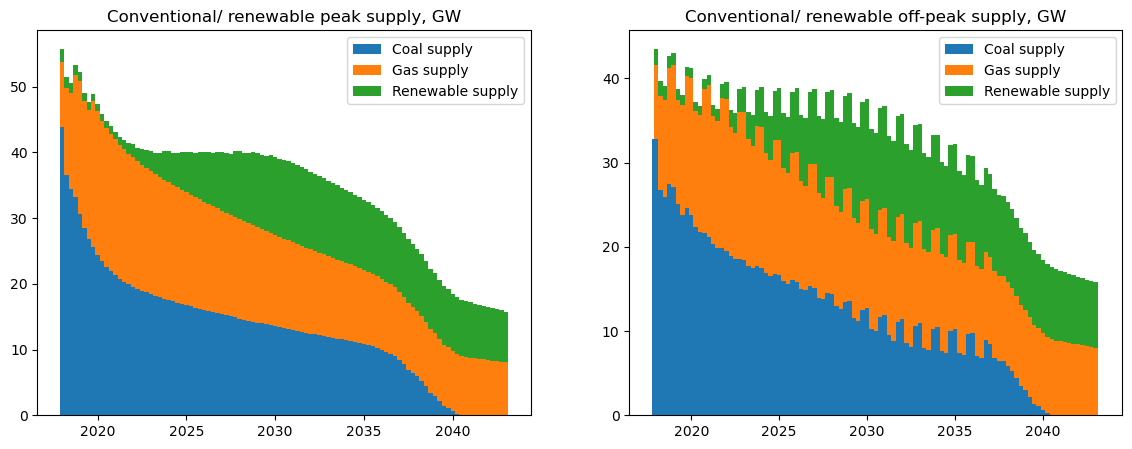

Elapsed time:  111.16998672485352


In [17]:
print('Elapsed time: ', elapsed)
out = sim.write(scenario_name)
try:
    os.mkdir(scenario_name)
except FileExistsError:
    print('Directory already exists')
os.system("cp common_params.py "+scenario_name+"/common_params.py")

# parameter files are copied to output directory; change this if you change agent types
os.system("cp coal.py "+scenario_name+"/coal.py")
os.system("cp gas.py "+scenario_name+"/gas.py")
os.system("cp renewable.py "+scenario_name+"/renewable.py")

os.system("cp "+scenario_name+'.csv '+scenario_name+"/"+scenario_name+".csv")


plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(2018+out['time'], out['peak price'], label='peak price')
plt.plot(2018+out['time'], out['offpeak price'], label='offpeak price')
plt.legend()
plt.title('Electricity price')
plt.subplot(122)

# Plotting the capacity for each agent type; modify this if you change agent types
plt.plot(2018+out['time'], out['Coal capacity'], label='Coal capacity')
plt.plot(2018+out['time'], out['Gas capacity'],label='Gas capacity')
plt.plot(2018+out['time'], out['Renewable capacity'], label='Renewable capacity')
plt.legend()
plt.title('Installed capacity')
#plt.savefig(scenario_name+"/"+'price_capacity.pdf', format='pdf')

plt.savefig('Na=5.pdf', format='pdf')

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(2018+out['time'], sim.pdemand, label='peak demand')
plt.plot(2018+out['time'], sim.opdemand, label='offpeak demand')
plt.legend()
plt.title('Electricity demand')
plt.subplot(122)

# Plotting the fuel prices; modify this if you change fuel types
plt.plot(2018+out['time'], out['Fuel 0'], label='Coal price')
plt.plot(2018+out['time'], out['Fuel 1'], label='Gas price')
plt.legend()
plt.title('Fuel price')
#plt.plot(2018+out['time'],np.interp(out['time'],cp["carbon tax"][0],cp["carbon tax"][1]))
plt.savefig(scenario_name+"/"+'demand_fuelprice.pdf',format='pdf')


plt.figure(figsize=(14,5))
plt.subplot(121)

# Plotting the supply for each agent; modify this if you change agent types
plt.bar(2018+out['time'],out['Coal peak supply'],width=0.25,label='Coal supply')
plt.bar(2018+out['time'],out['Gas peak supply'],width=0.25,
        bottom=out['Coal peak supply'],label='Gas supply')
plt.bar(2018+out['time'],out['Renewable peak supply'],width=0.25,
        bottom=out['Gas peak supply']+out['Coal peak supply'],label='Renewable supply')
#plt.ylim([0,80])
plt.title('Conventional/ renewable peak supply, GW')
plt.legend()
plt.subplot(122)
plt.bar(2018+out['time'],out['Coal offpeak supply'],width=0.5,label='Coal supply')
plt.bar(2018+out['time'],out['Gas offpeak supply'],width=0.25,
        bottom=out['Coal offpeak supply'],label='Gas supply')
plt.bar(2018+out['time'],out['Renewable offpeak supply'],width=0.25,
        bottom=out['Gas offpeak supply']+out['Coal offpeak supply'],label='Renewable supply')

plt.title('Conventional/ renewable off-peak supply, GW')

#plt.ylim([0,80])


plt.legend()
plt.savefig(scenario_name+"/"+'supply.pdf',format='pdf')
plt.show()



print('Elapsed time: ', elapsed)